<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

In [26]:
!pip install yellowbrick

In [95]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

import seaborn as sns

from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use("ggplot")

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [28]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
10316,cryptolocker,xmyjjraopuxrxbo,15,0.266667,3.189898,0,1.778151
1653,bamital,365fd2375ee7849084b0503fa349645f,32,0.000000,3.640320,24,0.698970
22356,gameoverdga,25y6te5587i01t2fzqsvnrgjk,25,0.000000,4.293661,10,0.000000
22793,necurs,unjkyyjhlarusw,14,0.428571,3.378783,0,4.143639
3935,cryptolocker,sqkrshdoiswl,12,0.583333,3.188722,0,1.690196


In [29]:
data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [30]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [31]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [32]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
22683,0.116639,-0.058110,0.809637,-0.498385,-0.722434
1856,2.216822,-1.346940,0.903181,3.678940,-0.811719
26786,-0.539668,0.144979,-0.237469,-0.498385,-0.134470
1184,2.216822,-0.831408,0.318049,2.729548,-0.546932
33653,-0.408407,1.144799,-0.256155,-0.498385,1.782516
40980,-0.802191,1.144799,-0.492925,-0.498385,-0.370473
29483,0.247900,0.821328,0.864322,-0.498385,-0.642722
21211,1.560515,-0.790038,1.329762,0.830764,-0.410109
17874,1.429253,-1.604706,1.368819,1.590278,-0.811719
23480,-0.933453,0.113734,-0.833959,-0.498385,-0.722434


Finally for convenience, we're going to merge the scaled features with the unscaled features.  

In [33]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [34]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
50605,alexa,extremerestraints,17,1.000000,2.939829,0,31.615138,0.247900,1.144799,-0.506507,-0.498385,5.104495
24492,necurs,ncvxlxlvjpke,12,0.250000,3.084963,0,0.000000,-0.408407,-0.917330,-0.256155,-0.498385,-0.811719
24519,necurs,wnhqkrmuverm,12,0.250000,3.251629,0,4.035950,-0.408407,-0.917330,0.031342,-0.498385,-0.056462
18815,gameoverdga,1sxxeq8npnj2p1oqak0upyqgkm,26,0.115385,4.026987,5,0.000000,1.429253,-1.287455,1.368819,0.451007,-0.811719
32595,nivdort,caseover,8,1.000000,2.750000,0,8.889270,-0.933453,1.144799,-0.833959,-0.498385,0.851751


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [89]:
kmeans = KMeans(n_clusters=2, n_init=2)
    
kmeans.fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]
 [ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]]
[1 1 1 ... 0 0 0]


In [90]:
final_data['dsrc'].value_counts()

dsrc
cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: count, dtype: int64

In [91]:
final_data['cluster_id'] = kmeans.labels_

In [92]:
final_data.head()

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id,dbs_default
0,bamital,949759d12e0ea541f49675fe4e71a65c,32,0.00000,3.515320,22,0.000000,2.216822,-1.604706,0.486203,3.678940,-0.811719,1,0
1,bamital,cbaa81d976688b971a43a745795cbb0f,32,0.09375,3.640320,20,0.477121,2.216822,-1.346940,0.701825,3.299183,-0.722434,1,0
2,bamital,0a175898661ddbad1b3bd99d14d62c6e,32,0.15625,3.593139,19,0.845098,2.216822,-1.175096,0.620440,3.109305,-0.653574,1,0
3,bamital,c5ee32668c5130c95a9d7eaf91e6b531,32,0.00000,3.694549,20,0.477121,2.216822,-1.604706,0.795370,3.299183,-0.722434,1,0
4,bamital,b1939fbdf8b57c2683abb9b041aa8518,32,0.18750,3.632049,19,0.903090,2.216822,-1.089174,0.687559,3.109305,-0.642722,1,0


## Visualize
We can plot the results of our clusters, but only a few features at a time b/c we need each feature to be on an axis. So we can select 2 features at a time to plot and see what the results are and if it looks like the clusters are separated in a clear way. Can I draw a line between them? Is that a requirement?

<Axes: xlabel='scaled_length', ylabel='scaled_ngram'>

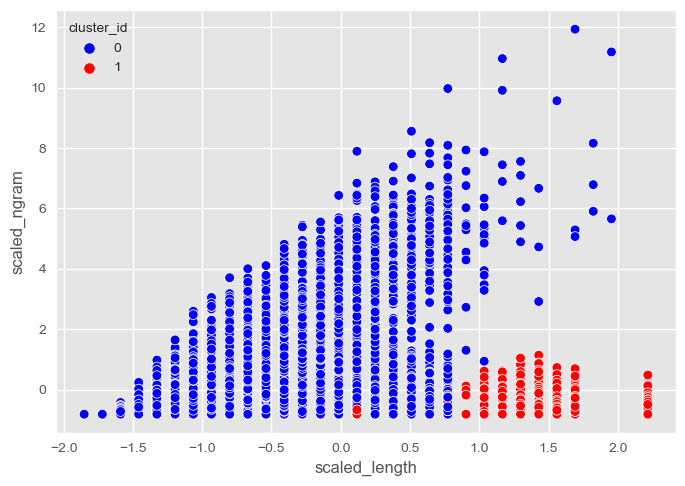

In [97]:
df = pd.DataFrame(np.random.rand(10,2), columns=["A", "B"])
df = final_data.loc[:,['scaled_length','scaled_ngram', 'cluster_id']]
dic = {0:"Blue", 1:"Red"}
sns.scatterplot(x="scaled_length", y="scaled_ngram", data=df, hue="cluster_id", palette = dic);


## Dig in
We can use our dataframe to summarize these results and look at the details of these clusters. 

In [39]:
# count the number of each 'dsrc' found in cluster number 1
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

dsrc
gameoverdga    9993
bamital        2500
necurs          140
alexa             3
Name: count, dtype: int64

In [40]:
final_data[final_data['cluster_id'] == 1]['domain'].sample(15)

21791         1ilaa2dsc697l1lje6k917gt8oj
22136          1iwqhu81pulrz7lcv3s1w9txhr
1257     1a2e148f7963bcb6929de5257d6bfebf
14532          1q1gq821h4hchs2357i82alqpz
15861            jaybr92h05sxvec747pbn4cs
1275     f3cd89170a17fe4716ffdc792b54819b
218      6cfee015006beefdd7472ba46c382b19
289      f5dbdc7eddaeee4e9cc251fb0022c0d5
22184           hsin2e1u1gwe1e1nxbia81ixl
18957          3gbiba15r2z231pgoxzm5ue14w
14021        1y72ccm1ex4t9y12pwkfm1fuibn9
13593           4qyoep1hrr8n17v9c6xssx3bt
16165          x673uutk8ofi17oooo81aei0nj
5        de679d29345e1e23210605d0bd3492f2
17614         134u25d1qvrym7luvmo51upifpo
Name: domain, dtype: object

In [41]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(15)

24537       bnocediokwpbjuqnj
27204                usewmqol
11785            fhyaalgdbsvt
32020    eqcyrefvscyixpgjgwyn
48646             otvest-mist
39479               cloudgone
35768                wifeborn
33590                thisfeed
40203                roomfive
51865                   sijex
42584          ashleyrnadison
29396     dybhyiqdsriqyaosfqn
26509       karyqcaisfhglskjs
31743                 vlppocp
36503                casekind
Name: domain, dtype: object

In [42]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

9249     feayggmwawgcysy
5920        hfauvmeierfr
10447    dctpnwtrcmohyaq
10488    tocvoscngjmkvfb
9846       jjqyubkgvrbtv
Name: domain, dtype: object

In [43]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

1663    3ac3aee1f5eb6c47efca7f1b20b46b5c
2383    d7ac8c6b0f65e6bb34ed31e96a5bd8b3
967     1557136eb042a2065f935fb6af0bbca1
2472    fe71f17daf8c1309763d230e4722f4c0
1593    61f6b45aeca015ab5472c38979bc2962
2443    fd37bd7d886551ad5286b53c38432c2f
963     08124f0a44154a50826dd136b479e5fd
2341    4f3410fb82738a9eee51bd2cda190159
2127    e41615c5239418b88903caf81cf90cef
2429    54e7463ea77113c4c160bd0c8f66abd5
Name: domain, dtype: object

In [44]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

41870       spendought
40372         darkrise
33241       equaltaste
35494         mostbody
39726        sickeight
37979        hangseven
36671     milknovember
38221         wentlady
35719         pickborn
38728    whichnovember
Name: domain, dtype: object

In [45]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22546    kujnifxvqwkpyytegqohv
22632     xwhqnkkesylwbydfnsxm
22711       wuiioaeyklhgcxwmad
22736       efkwmijhtpxsgrhfgq
22743      shngncqtfjlfhdjrtks
                 ...          
31897    pyskufklybvjhfpywtvlc
31956      ixhlkocwfwwdktjmdvj
32246     sxgkkqnnfjsoyhebpypw
32434    cqvkgxsntoevqbkxnyvyf
32456    qxvbbtlxhwguongdywukl
Name: domain, Length: 140, dtype: object

In [46]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
36186,nivdort,whomwing,8,1.000000,2.750000,0,6.823103,-0.933453,1.144799,-0.833959,-0.498385,0.465104,0
25693,necurs,ocwctsjufecgthycem,18,0.666667,3.503258,0,3.890756,0.379162,0.228297,0.465398,-0.498385,-0.083633,0
16169,gameoverdga,19hfhb718al3zqtc6uvu3h38a1,26,0.115385,3.921030,11,0.000000,1.429253,-1.287455,1.186045,1.590278,-0.811719,1
31564,necurs,jnseggvgcrevskkp,16,0.687500,3.202820,0,5.022577,0.116639,0.285579,-0.052854,-0.498385,0.128168,0
27264,necurs,xblefgs,7,0.857143,2.807355,0,2.318063,-1.064714,0.752012,-0.735023,-0.498385,-0.377934,0


## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method: 
1. Calc k-means clustering on the dataset for a range of values for k (say from 1-10).
2. For each value of k, compute Sum of squared distances of samples to their closest cluster center. Often called the Within-Cluster Sum of Squares.
3. Plot these values for each k
4. Determine best value of k based on inflection point (elbow) in the graph.
   
If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. 


### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score. That is, do you see an elbow in this graph? That should be the 'ideal' number of clusters for our k-means model of this data. 

Try different numbers for the sample and see how this affects the graph. 
Try differen values for the range of k to see how this changes the inflection point

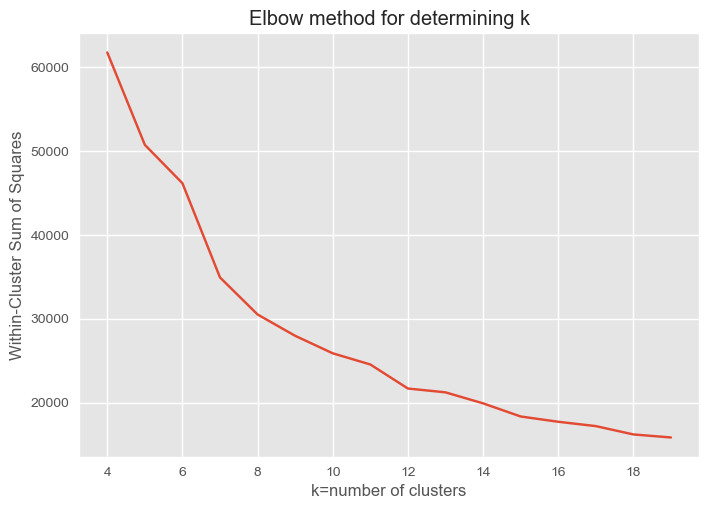

In [47]:
WCSS=[]
for i in range(4,20):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(final_data[scaled_feature_columns].sample(50000))
  WCSS.append(kmeans.inertia_)
WCSS

plt.plot(range(4,20),WCSS);
plt.ylabel('Within-Cluster Sum of Squares')
plt.xlabel('k=number of clusters')
plt.title('Elbow method for determining k');

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

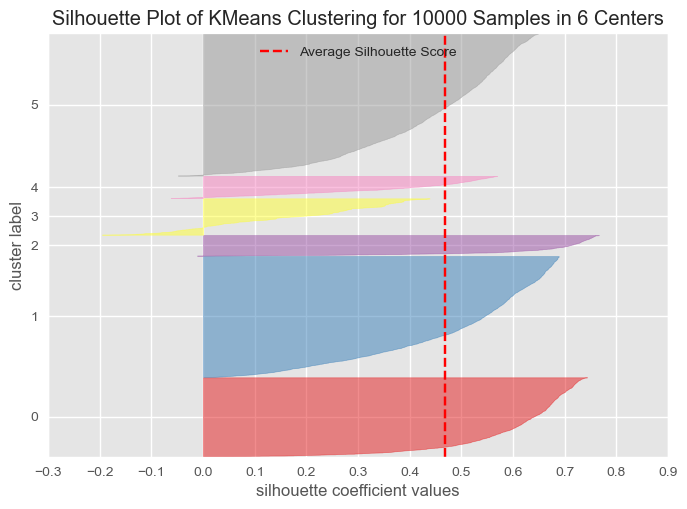

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
visualizer = SilhouetteVisualizer( KMeans(n_clusters=6, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). 

First we will create an anomaly dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [50]:
dga_data = pd.read_csv('../data/dga_features_final_df_domain.csv')
print(dga_data.isDGA.value_counts())

isDGA
dga      1000
legit    1000
Name: count, dtype: int64


In [51]:
is_dga = dga_data[dga_data['isDGA']=='dga'].sample(20)
not_dga = dga_data[dga_data['isDGA']=='legit']

In [52]:
print(len(is_dga))
print(len(not_dga))

10
1000


In [53]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

isDGA
legit    1000
dga        10
Name: count, dtype: int64

In [54]:
dga_anomaly_data_domain = dga_anomaly_data
dga_anomaly_data = dga_anomaly_data.drop('domain',axis=1)

#### Now use this dataset that conatins only a few anomalies in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. The code is below, but if you want you can try to use  the Min Max Scaler after you fir the model to see if it changes the resuls. 

In [56]:
dga_anomaly_data.head()

,isDGA,ngrams
913,dga,357.265793
780,dga,591.538384
756,dga,1288.619048
681,dga,733.531453
85,dga,815.635354


In [67]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data.loc[:,'ngrams'].values.reshape(-1, 1))

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [68]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [69]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

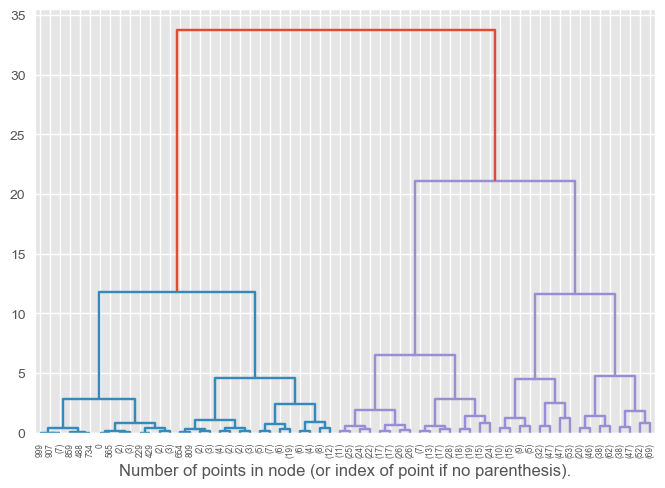

In [71]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [72]:
dga_anomaly_data_domain.iloc[0,:]

isDGA                                  dga
domain    2a50089de733fcb3ad58f3c150b92581
ngrams                          357.265793
Name: 913, dtype: object

In [73]:
dga_anomaly_data_domain.iloc[3,:]

isDGA                            dga
domain    ughukrpjfhirgkrlzrwwcvvxtd
ngrams                    733.531453
Name: 681, dtype: object

In [74]:
dga_anomaly_data_domain.iloc[5,:]

isDGA                         dga
domain    vsgaprpmrtwtijfusgqgxct
ngrams                  967.51603
Name: 514, dtype: object

In [75]:
dga_anomaly_data_domain.iloc[29,:]

isDGA            legit
domain    skidrowgames
ngrams      1337.05303
Name: 1019, dtype: object

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [76]:
dbscan = DBSCAN(min_samples=50)

In [77]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [78]:
final_data['dbs_default'].value_counts()

dbs_default
 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: count, dtype: int64

In [79]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

dsrc
cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: count, dtype: int64

In [80]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
25907,necurs,gwyrdtgswgaqkvnbdhy
39055,nivdort,wentkind
39920,nivdort,lordeasy
9303,cryptolocker,vvojhppourhird
42500,alexa,aili
7935,cryptolocker,wvaymryihmkw
5599,cryptolocker,qtfyfkpoicyei
7966,cryptolocker,vbryipjlopen
30214,necurs,scaufuthbnabudaftlrcl
23410,necurs,miiodjvdvdwaw


In [81]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

52147     alexa
48803     alexa
50417     alexa
52233     alexa
31069    necurs
46861     alexa
46128     alexa
49387     alexa
50572     alexa
44669     alexa
Name: dsrc, dtype: object

In [82]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

35490     mostdare
36279    cloudcity
32647    pickshirt
36833     feltpure
40438    darkshade
Name: domain, dtype: object

In [83]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

dsrc
gameoverdga    9973
Name: count, dtype: int64

In [84]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

dsrc
cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: count, dtype: int64

In [85]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

7293     fycecmuwblbygam
4275     keblmtusevvlbyi
6536       aarnfbgfghpdr
6017        dbyygvwoivog
10629       muvtvdascvei
4541       pkfxghpbyjqdf
7133     funftcodynxpxnc
6032        aqigeanewuju
8224     wgsmcfcivfemwqs
8441      athkgbygkncyfd
Name: domain, dtype: object

In [86]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

28970              bvfqgxtoud
22899       heowcepisqvctdnmy
30722          feoupxhbvprmig
26879    ogqbomfuknqjrgswlaaj
29290       ktxaxbtayfikujdke
30977    vqdbusmxothlhmukvkcx
24876                tuticrde
30791          grirlbxfvheetn
25298        pgmwgbvmpfoiewfr
27670               fqjwielik
Name: domain, dtype: object